In [1]:
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

import cv2
import Augmentor as au

import unet_kkweon


from IPython import display
%matplotlib inline

In [2]:
path = "../data/stage_1_processed/"

### Load data

In [3]:
train_names = os.listdir(path + "train")
val_names = os.listdir(path + "val")

In [4]:
train_data = [np.load(path + "train/" + name) for name in train_names]
val_data = [np.load(path + "val/" + name) for name in val_names]

In [5]:
train_data = [np.concatenate((x,
                              np.expand_dims(cv2.morphologyEx(x[:,:,1], cv2.MORPH_GRADIENT, np.ones((2,2))),2)), -1)\
              for x in train_data ]

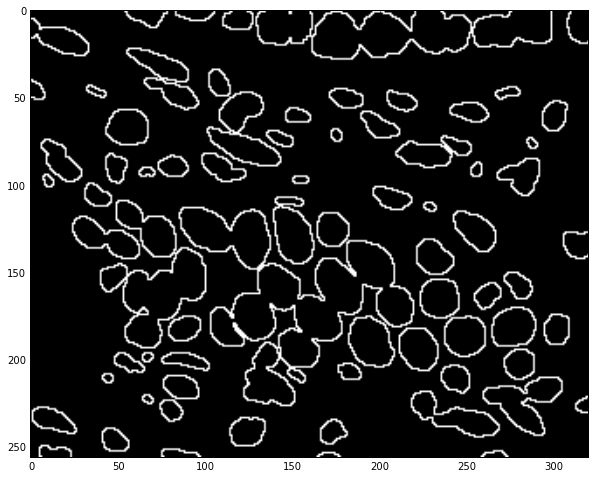

In [6]:
plt.figure(figsize = (10,10))
plt.imshow(train_data[52][:,:,2],cmap='gray')
plt.show()

### Create network and session

In [401]:
def conv_conv_pool(input_,
                   n_filters,
                   training,
                   flags,
                   name,
                   pool=True,
                   activation=tf.nn.relu):
    """{Conv -> BN -> RELU}x2 -> {Pool, optional}

    Args:
        input_ (4-D Tensor): (batch_size, H, W, C)
        n_filters (list): number of filters [int, int]
        training (1-D Tensor): Boolean Tensor
        name (str): name postfix
        pool (bool): If True, MaxPool2D
        activation: Activaion functions

    Returns:
        net: output of the Convolution operations
        pool (optional): output of the max pooling operations
    """
    net = input_

    with tf.variable_scope("layer{}".format(name)):
        for i, F in enumerate(n_filters):
            net = tf.layers.conv2d(
                net,
                F, (3, 3),
                activation=None,
                padding='same',
                #kernel_regularizer=tf.contrib.layers.l2_regularizer(flags.reg),
                name="conv_{}".format(i + 1))
            net = tf.layers.batch_normalization(
                net, training=training, name="bn_{}".format(i + 1))
            net = activation(net, name="relu{}_{}".format(name, i + 1))

        if pool is False:
            return net

        pool = tf.layers.max_pooling2d(
            net, (2, 2), strides=(2, 2), name="pool_{}".format(name))

        return net, pool


def upconv_concat(inputA, input_B, n_filter, flags, name):
    """Upsample `inputA` and concat with `input_B`

    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation

    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    up_conv = upconv_2D(inputA, n_filter, flags, name)

    return tf.concat(
        [up_conv, input_B], axis=-1, name="concat_{}".format(name))


def upconv_2D(tensor, n_filter, flags, name):
    """Up Convolution `tensor` by 2 times

    Args:
        tensor (4-D Tensor): (N, H, W, C)
        n_filter (int): Filter Size
        name (str): name of upsampling operations

    Returns:
        output (4-D Tensor): (N, 2 * H, 2 * W, C)
    """

    return tf.layers.conv2d_transpose(
        tensor,
        filters=n_filter,
        kernel_size=2,
        strides=2,
        #kernel_regularizer=tf.contrib.layers.l2_regularizer(flags.reg),
        name="upsample_{}".format(name))


def make_unet(X, training, flags=None):
    """Build a U-Net architecture

    Args:
        X (4-D Tensor): (N, H, W, C)
        training (1-D Tensor): Boolean Tensor is required for batchnormalization layers

    Returns:
        output (4-D Tensor): (N, H, W, C)
            Same shape as the `input` tensor

    Notes:
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    """
    #net = X / 127.5 - 1
    net = X
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, flags, name=1)
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, flags, name=2)
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, flags, name=3)
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, flags, name=4)
    conv5 = conv_conv_pool(
        pool4, [128, 128], training, flags, name=5, pool=False)

    up6 = upconv_concat(conv5, conv4, 64, flags, name=6)
    conv6 = conv_conv_pool(up6, [64, 64], training, flags, name=6, pool=False)

    up7 = upconv_concat(conv6, conv3, 32, flags, name=7)
    conv7 = conv_conv_pool(up7, [32, 32], training, flags, name=7, pool=False)

    up8 = upconv_concat(conv7, conv2, 16, flags, name=8)
    conv8 = conv_conv_pool(up8, [16, 16], training, flags, name=8, pool=False)

    up9 = upconv_concat(conv8, conv1, 8, flags, name=9)
    conv9 = conv_conv_pool(up9, [8, 8], training, flags, name=9, pool=False)

    return tf.layers.conv2d(
        conv9,
        1, (1, 1),
        name='final',
        #activation=tf.nn.sigmoid,
        padding='same')


In [402]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [403]:
x = tf.placeholder("float", shape=[None, None, None, 1])
target = tf.placeholder("float", shape=[None, None, None, 1])
training = tf.placeholder('bool')

In [404]:
out_logits = make_unet(x, training)

In [405]:
out = tf.nn.sigmoid(out_logits)

In [406]:
loss = tf.reduce_mean(tf.losses.log_loss(target, out))

In [407]:
optimizer = tf.train.AdamOptimizer(beta2=0.98)
train_step = optimizer.minimize(loss)

In [408]:
sess.run(tf.global_variables_initializer())

In [409]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

### Augmentation + batch_iterator

In [356]:
def mirror(im):
    shape = im.shape
    h = lambda arr: np.hstack((arr[:,(shape[1] // 2)::-1,:], arr, arr[:,:(shape[1] // 2):-1,:]))
    v = lambda arr: np.vstack((arr[shape[0] // 2::-1,:,:], arr, arr[:shape[0] // 2:-1,:,:]))

    return v(h(im))

In [357]:
def crop(im, shape):
    #shape = (int(im.shape[0] * 0.7), int(im.shape[1] * 0.7))
    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [358]:
u16_up = lambda x : (x // 16 + 1) * 16
u16_d = lambda x : (x // 16) * 16

In [359]:
def get_16_im(im):
    shape = im.shape
    big_im = mirror(im)
    pos_x = shape[0] // 2
    pos_y = shape[1] // 2
    
    
    shape_shift = (u16_up(shape[0]), u16_up(shape[1]))
    
    #prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(big_im[x: x + shape_shift[0], y : y + shape_shift[1], :], 0), training : False})
    return big_im[pos_x: pos_x + shape_shift[0], pos_y : pos_y + shape_shift[1], :]

In [189]:
p = au.Pipeline()
#p.rotate(1, 25, 25)
p.flip_random(1)
#p.invert(1)
#p.random_distortion(1, 10,10,2)
#p.skew(1)


In [190]:
g = p.keras_generator_from_array(np.expand_dims(train_data[0][:,:,:], 0) ,np.ones(1), 1, False)

In [191]:
gens = np.array([p.keras_generator_from_array(np.expand_dims(mirror(im), 0) ,np.ones(1), 1, False) for im in train_data])

In [410]:
gens = np.array([([[x]] for x in [im]*9999) for im in train_data])

In [411]:
def iterate_minibatches(x, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt]

In [412]:
train_loss = []
val_scores = []

In [413]:
from tqdm import tqdm
import time

In [414]:
epochs = 10

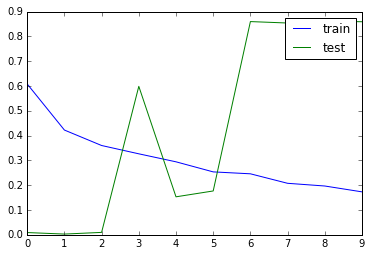

23it [00:09,  2.50it/s]


KeyboardInterrupt: 

In [416]:
for epoch in range(epochs):
    curr_loss = 0
    for i, (gen_batch) in tqdm(enumerate(iterate_minibatches(gens[:],20))):
        images = [next(g)[0][0] for g in gen_batch]
        shapes = np.concatenate(([np.array(image.shape).reshape(1, -1) for image in images]))
        
        batch_shape = (min(256, u16_d(shapes[:,0].min() - 1)), min(256, u16_d(shapes[:,1].min() - 1)))
        images = [crop(im, batch_shape) for im in images]
        
        batch_x = np.expand_dims(np.concatenate([np.expand_dims(im[:,:,0], 0) for im in images]), 3) / 255
        batch_y = np.concatenate([np.expand_dims(im[:,:,1:2], 0) for im in images])
        
        batch_loss = sess.run([train_step,loss], feed_dict={x : batch_x, target: batch_y, training : True})
        curr_loss += batch_loss[1]

    train_loss.append(curr_loss / (i + 1)) 
    
    val_score = 0
#     for val_im in tqdm(val_data[:]):
#         prediction = sess.run(out, feed_dict={x : np.expand_dims(get_16_im(val_im[:,:,:1]), 0), training : False})
#         mask = prediction[0][:val_im.shape[0],:val_im.shape[1],:1]
#         mask_int = (mask > 0.5).astype(int)[:,:,0].astype('uint8')
#         iou = np.logical_and((mask_int == val_im[:,:,1]),val_im[:,:,1]).sum() / val_im[:,:,1].sum()
        
    for val_im in tqdm(val_data[:]):
        prediction = sess.run(out, feed_dict={x : np.expand_dims(get_16_im(val_im[:,:,:1]), 0), training : False})
        mask = prediction[0][:val_im.shape[0],:val_im.shape[1],:1]
        mask_int = (mask > 0.5).astype(int)[:,:,0].astype('uint8')
        iou = (mask_int == val_im[:,:,1]).sum() / (val_im[:,:,1].shape[0] * val_im[:,:,1].shape[1])
        
        val_score += iou
        
    
    
#     if epoch != 0:
#         if val_score < val_scores[-1]:
#             save_model("../model/model_1/")
            
            
    val_scores.append(val_score / len(val_data))

    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    plt.plot(val_scores, label='test')
    plt.legend()
    plt.show()
            
#     val_loss = sess.run(loss,  feed_dict={inp : X[4000:].reshape(-1, 100), target: y[4000:].reshape(-1, 100)})
#     val_losses.append(val_loss)
#     val_x.append(len(losses_each_n))
    
#     curr_loss == 0

        #print(batch_loss[1])

In [380]:
iou

0.9789276123046875

In [373]:
images

[array([3, 0, 0], dtype=uint8),
 array([14,  0,  0], dtype=uint8),
 array([5, 0, 0], dtype=uint8),
 array([154,   0,   0], dtype=uint8),
 array([152,   0,   0], dtype=uint8),
 array([27,  0,  0], dtype=uint8),
 array([13,  0,  0], dtype=uint8),
 array([4, 0, 0], dtype=uint8),
 array([77,  1,  0], dtype=uint8),
 array([224,   0,   0], dtype=uint8),
 array([12,  0,  0], dtype=uint8),
 array([172,   0,   0], dtype=uint8),
 array([11,  0,  0], dtype=uint8),
 array([6, 0, 0], dtype=uint8),
 array([179,   0,   0], dtype=uint8),
 array([13,  0,  0], dtype=uint8),
 array([116,   0,   0], dtype=uint8),
 array([13,  0,  0], dtype=uint8),
 array([219,   0,   0], dtype=uint8),
 array([15,  0,  0], dtype=uint8)]

In [372]:
shapes

array([[3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3]])

In [300]:
for val_im in tqdm(val_data[1:2]):
    prediction = sess.run(out, feed_dict={x : np.expand_dims(get_16_im(val_im[:,:,:1]), 0), training : False})
    mask = prediction[0][:val_im.shape[0],:val_im.shape[1],:1]
    mask_int = (mask > 0.5).astype(int)[:,:,0].astype('uint8')
    iou = (mask_int == val_im[:,:,1]).sum() / (val_im[:,:,1].shape[0] * val_im[:,:,1].shape[1])

100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


In [301]:
mask_int == val_im[:,:,1]

array([[ True,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [302]:
iou

0.33909980106100795

In [340]:
val_data[0]

214

In [425]:
im = val_data[0][:,:,:]
prediction = sess.run(out, feed_dict={x : np.expand_dims(get_16_im(im[:,:,:1]), 0), training : False})

In [426]:
mask = prediction[0][:im.shape[0],:im.shape[1],:1]

In [427]:
#(mask == im[:,:,1]).sum() / (mask.shape[0] * mask.shape[1])

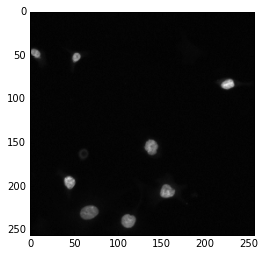

In [428]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow(im[:,:,0], cmap='gray')
plt.show()

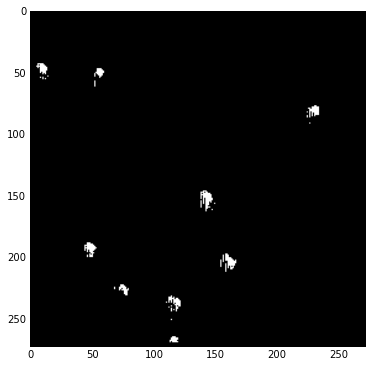

In [429]:
plt.figure(figsize=(6,6))
plt.imshow((prediction[0,:,:,0] > 0.5).astype(float), cmap='gray')
plt.show()

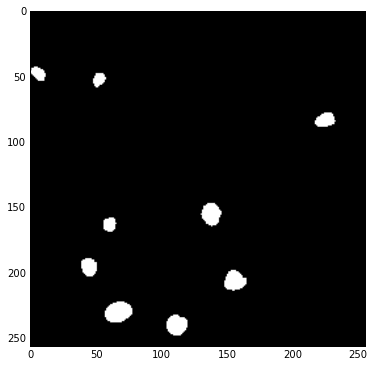

In [430]:
plt.figure(figsize=(6,6))
plt.imshow(im[:,:,1], cmap='gray')
plt.show()

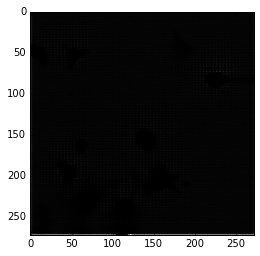

In [400]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow((prediction[0,:,:,0] ).astype(float), cmap='gray')
plt.show()

In [397]:
(prediction[0,:,:,0] < 1).sum()

73984

In [399]:
prediction[0,:,:,0]

array([[ 0.23792891,  0.18138488,  0.17746097, ...,  0.11622853,
         0.14882194,  0.31160143],
       [ 0.19506824,  0.14958581,  0.07271095, ...,  0.02649408,
         0.07109028,  0.34236488],
       [ 0.1125815 ,  0.12523165,  0.02593599, ...,  0.02148531,
         0.05426122,  0.22604905],
       ..., 
       [ 0.18813436,  0.17537072,  0.02569957, ...,  0.03841708,
         0.05215421,  0.23445144],
       [ 0.28400499,  0.15761682,  0.05214234, ...,  0.11246896,
         0.11453896,  0.50444877],
       [ 0.36271894,  0.2885918 ,  0.28259546, ...,  0.47109088,
         0.45756462,  0.71003157]], dtype=float32)

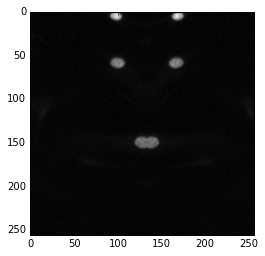

In [201]:
plt.imshow(batch_x[15][:,:,0], cmap='gray')
plt.show()

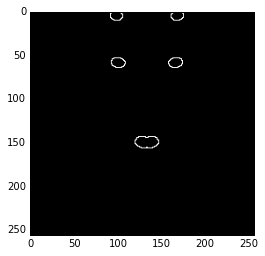

In [202]:
plt.imshow(batch_y[15][:,:,0], cmap='gray')
plt.show()

In [197]:
batch_y.shape

(20, 256, 256, 1)

In [204]:
batch_y.min()

0

In [444]:
val_data[0].shape

(360, 360, 2)

In [415]:
batch_y.shape

(3, 511, 511, 2)

In [411]:
np.expand_dims(np.concatenate(batch_x), 3).shape

(3, 511, 511, 1)

In [405]:
images[0].shape

(511, 511, 3)

In [436]:
batch_y[2][:,:,0]

array([[  0,   0,   0, ..., 255, 255, 254],
       [  0,   0,   0, ..., 255, 255, 254],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [428]:
batch_x[0].shape

(256, 256, 1)

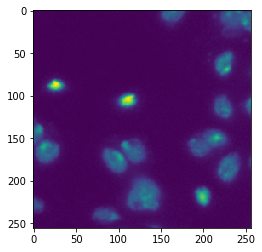

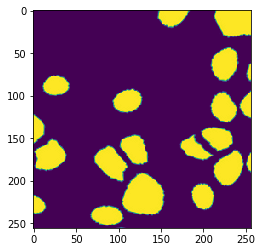

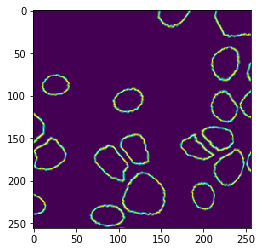

In [435]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow(batch_x[2][:,:,0])
plt.show()
plt.imshow(batch_y[2][:,:,0])
plt.show()
plt.imshow(batch_y[2][:,:,1])
plt.show()

In [366]:
im[:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

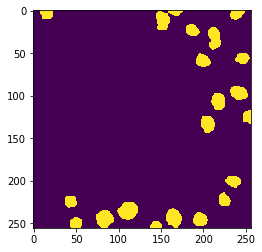

In [247]:
plt.imshow(val_data[23][:,:,1])
plt.show()

In [61]:
gr = tf.get_default_graph()
#gr = sess.graph
#gr = tf.get_default_session().graph

writer = tf.summary.FileWriter("../tf_logs", gr)

# generic unet :)

In [13]:
import tf_unet.unet as unet_module
unet_module = reload(unet_module)

In [11]:
with sess.as_default():
    unet = unet_module.Unet(channels=1)

2018-04-08 15:11:02,022 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [20]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [21]:
x = tf.placeholder("float", shape=[None, None, None, 1])
y = tf.placeholder("float", shape=[None, None, None, 2])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
logits, variables, offset = unet_module.create_conv_net(x, keep_prob, 1, 2)

2018-04-08 15:15:32,235 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [22]:
sess.run(tf.global_variables_initializer())

In [28]:
x_ = np.zeros((1,100,100,1))


In [29]:
sess.run(logits, feed_dict={x : x_, keep_prob : 1}).shape

(1, 160, 160, 2)

In [68]:
#loss = tf.reduce_mean(categorical_crossentropy(target, inp))
loss = tf.reduce_mean(tf.losses.mean_squared_error(target, out))

In [69]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)